# Capstone Project: Part 5 Time Series Modeling with Sktime

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

plt.style.use('fivethirtyeight')
import sktime
import statsmodels
import pmdarima
from sklearn.model_selection import train_test_split
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_squared_error
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.utils.plotting import plot_series
import pmdarima as pmd

# This will allow us to avoid a FutureWarning when plotting.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# read in training and testing set
tdor = pd.read_csv('../Data/processed_data/tdor_presplit.csv')

In [3]:
tdor['deaths']= 1

In [4]:
# converting the date column to datetime
tdor['date'] = pd.to_datetime(tdor['date'].str.zfill(6), format = '%Y-%m-%d')


In [5]:
# dropping columns that are not needed for time series analysis
tdor = tdor.drop(columns=['name','age','state_province','country','latitude','longitude','category','cause_of_death','description','year','city'])

In [6]:
# Set Date to be in the index
tdor.set_index('date', inplace=True)

# Sort the index
tdor.sort_index(inplace=True)


In [7]:
tdor_monthly = tdor.groupby(pd.Grouper(freq='M')).sum()


In [8]:
y=tdor_monthly

In [9]:
y_train, y_test = temporal_train_test_split(y=y)

<Figure size 1152x288 with 0 Axes>

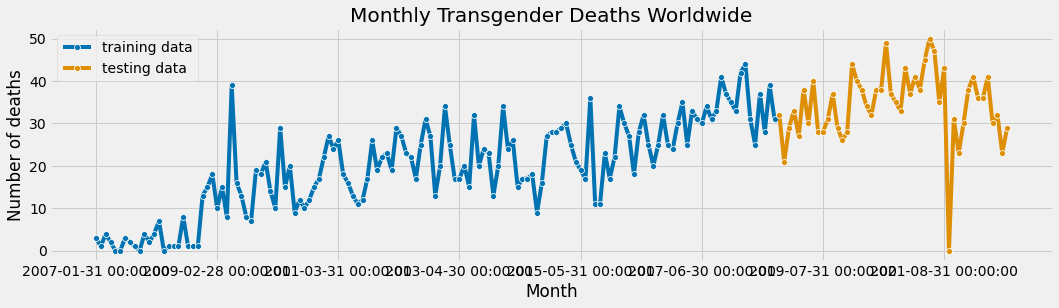

In [10]:
plt.figure(figsize = (16,4))
plot_series(y_train, y_test, labels=['training data', 'testing data'])
plt.title("Monthly Transgender Deaths Worldwide")
plt.xlabel("Month")
plt.ylabel("Number of deaths")
# locator = tdor.YearLocator()
# plt.gca().xaxis.set_major_locator(locator)
# plt.gcf().autofmt_xdate();
plt.show()

## Baseline - last value 

In [11]:
horizon = np.arange(1, y_test.shape[0])

In [12]:
base_last = NaiveForecaster(strategy = "last")

In [13]:
base_last.fit(y_train)

NaiveForecaster()

In [14]:
y_last = base_last.predict(fh=horizon)

/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:110: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:565: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)


In [15]:
mean_squared_error(y_test[1:],y_last,squared=False)

9.028324224232996

In [16]:
seasonal_last = NaiveForecaster(strategy = "last", sp=12)
seasonal_last.fit(y_train)
y_seasonal_last = seasonal_last.predict(fh=horizon)

/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:110: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:565: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)


In [17]:
mean_squared_error(y_test[1:],y_seasonal_last,squared=False)

11.001934065949012

<Figure size 1152x288 with 0 Axes>

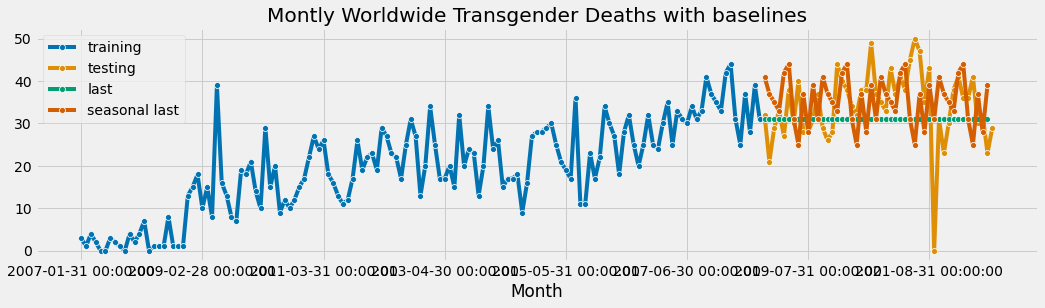

In [18]:
plt.figure(figsize = (16,4))
plot_series(y_train, y_test, y_last, y_seasonal_last, 
            labels = ['training', 'testing', 'last', 'seasonal last'])
plt.title("Montly Worldwide Transgender Deaths with baselines")
plt.xlabel("Month")
plt.show()

## Drift forecast

In [19]:
drift = NaiveForecaster(strategy = 'drift')

In [20]:
drift.fit(y_train)

NaiveForecaster(strategy='drift')

In [21]:
y_drift = drift.predict(fh = horizon)

/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:110: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:565: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)


In [22]:
mean_squared_error(y_test[1:],y_drift,squared=False)

8.773024418455048

<Figure size 1152x288 with 0 Axes>

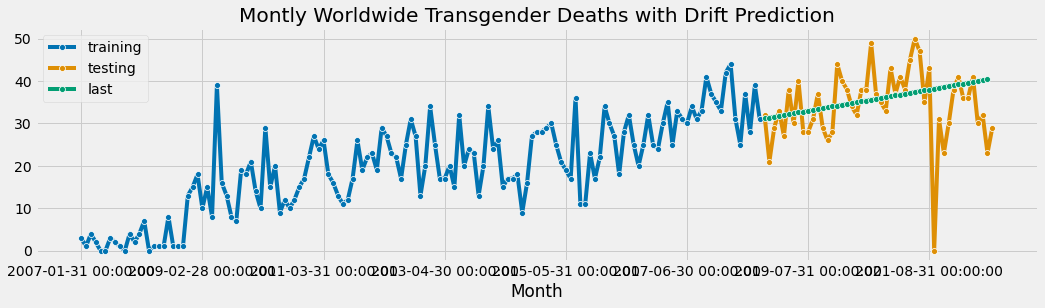

In [23]:
plt.figure(figsize = (16,4))
plot_series(y_train, y_test, y_drift, 
            labels = ['training', 'testing', 'last'])
plt.title("Montly Worldwide Transgender Deaths with Drift Prediction")
plt.xlabel("Month")
plt.show()


## SARIMA/AutoARIMA in Sktime


In [24]:
auto_arima = AutoARIMA(sp = 12)

In [25]:
auto_arima.fit(y_train)

/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/t

AutoARIMA(sp=12)

In [26]:
y_aa = auto_arima.predict(fh = horizon)

/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:565: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)


In [27]:
mean_squared_error(y_test[1:],y_aa,squared=False)

11.858306361208278

<Figure size 1152x288 with 0 Axes>

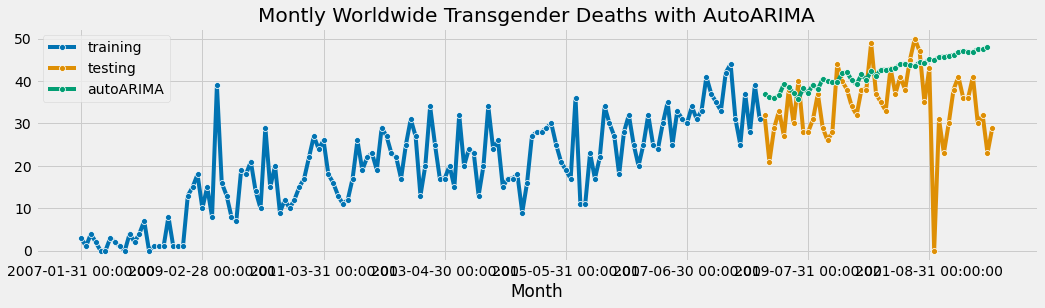

In [28]:
plt.figure(figsize = (16,4))
plot_series(y_train, y_test, y_aa, 
            labels = ['training', 'testing', 'autoARIMA'])
plt.title("Montly Worldwide Transgender Deaths with AutoARIMA")
plt.xlabel("Month")
plt.show()

## Holt-Winters

In [29]:
holt = AutoETS(auto = True, sp = 12, n_jobs=-1)

In [30]:
holt.fit(y_train)

/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/forecasting/ets.py:248: UserWarning: Warning: time series is not strictly positive,multiplicative components are ommitted
  warnings.warn(


AutoETS(auto=True, n_jobs=-1, sp=12)

In [31]:
y_holt = holt.predict(fh = horizon)

/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:81: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:83: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:86: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:565: FutureWarning: Timestamp.freqstr is deprecate

In [32]:
mean_squared_error(y_test[1:],y_holt,squared=False)

11.798789393037225

<Figure size 1152x288 with 0 Axes>

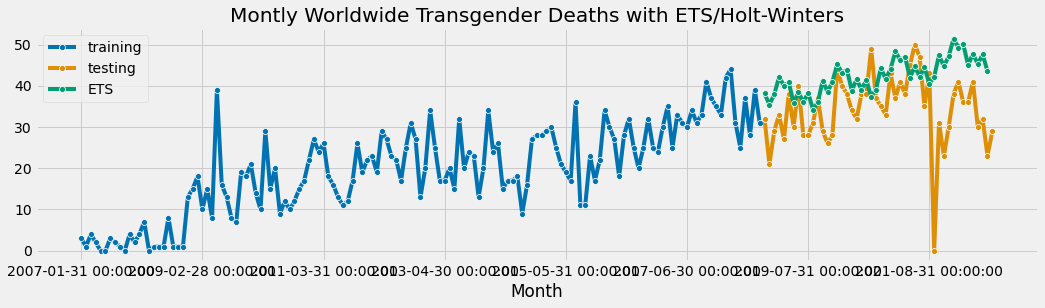

In [33]:
plt.figure(figsize = (16,4))
plot_series(y_train, y_test, y_holt, 
            labels = ['training', 'testing', 'ETS'])
plt.title("Montly Worldwide Transgender Deaths with ETS/Holt-Winters")
plt.xlabel("Month")
plt.show()

## Manual

In [34]:
holt_bad = AutoETS(sp = 12, n_jobs=-1)

In [35]:
holt_bad.fit(y_train)

AutoETS(n_jobs=-1, sp=12)

In [36]:
y_holt2 = holt_bad.predict(fh = horizon)

/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:81: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:83: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:86: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:565: FutureWarning: Timestamp.freqstr is deprecate

In [37]:
mean_squared_error(y_test[1:],y_holt2,squared=False)

8.437241002552957

<Figure size 1152x288 with 0 Axes>

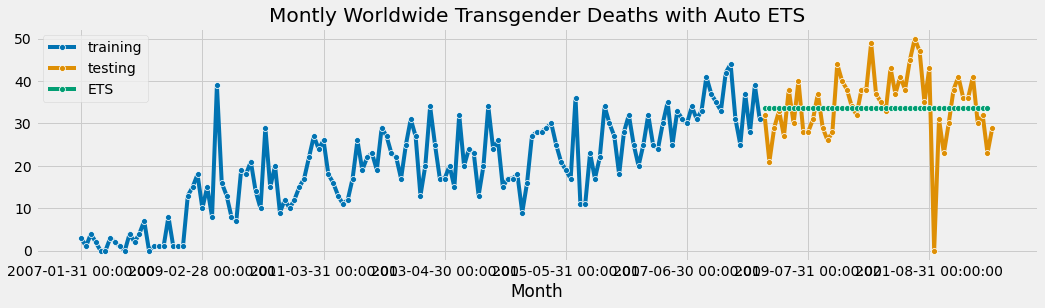

In [38]:
plt.figure(figsize = (16,4))
plot_series(y_train, y_test, y_holt2, 
            labels = ['training', 'testing', 'ETS'])
plt.title("Montly Worldwide Transgender Deaths with Auto ETS")
plt.xlabel("Month")
plt.show();

## Ensemble forecasts 


In [39]:
forecasters = [
    ("aa", auto_arima),
    ("holt", holt)
]
aef = AutoEnsembleForecaster(forecasters=forecasters, n_jobs = -1)

In [40]:
aef.fit(y_train)

/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/forecasting/ets.py:248: UserWarning: Warning: time series is not strictly positive,multiplicative components are ommitted
  warnings.warn(
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: Runti

AutoEnsembleForecaster(forecasters=[('aa', AutoARIMA(sp=12)),
                                    ('holt',
                                     AutoETS(auto=True, n_jobs=-1, sp=12))],
                       n_jobs=-1)

In [41]:
y_aef = aef.predict(fh = horizon)

/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:565: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:81: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:83: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/Users/ranyasatkuna/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sktime/utils/datetime.py:86: Future

In [42]:
mean_squared_error(y_test[1:],y_aef,squared=False)

11.759082693294275

<Figure size 1152x288 with 0 Axes>

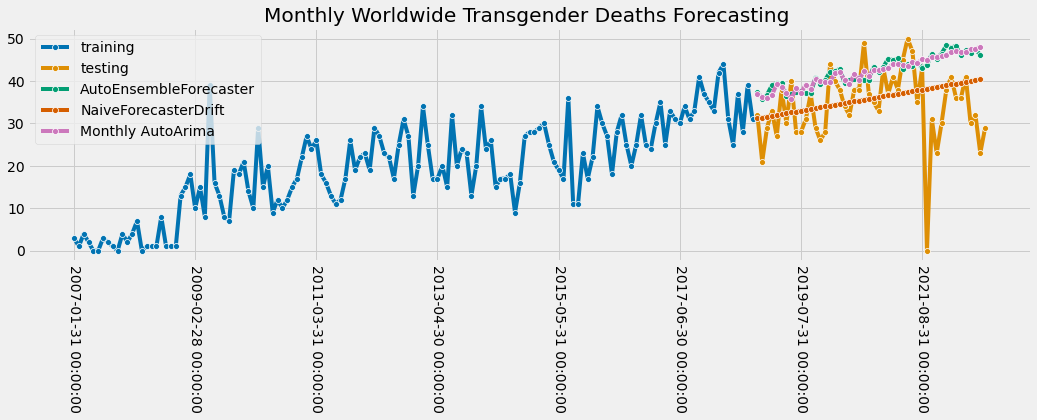

<Figure size 432x288 with 0 Axes>

In [43]:
plt.figure(figsize = (16,4))
plot_series(y_train, y_test, y_aef, y_drift, y_aa,
            labels = ['training', 'testing', 'AutoEnsembleForecaster', 'NaiveForecasterDrift','Monthly AutoArima'])
plt.title("Monthly Worldwide Transgender Deaths Forecasting ")
plt.xticks(rotation=-90)
plt.show();
# plt.savefig('monthlyforecastingarima')

n. The above image describes how different time series analysis models forecast Worldwide transgender deaths.